In [1]:
import numpy as np
from PIL import Image
from pathlib import Path
from matplotlib import pyplot as plt

DATA_PATH = Path('./orl-dataset')

# Load dataset in numpy array

In [5]:
height, width = 112, 92
faces = np.zeros((40, 10, height, width))

for i in range(40):
    for j in range(10):
        faces[i, j, :, :] = np.array(Image.open(DATA_PATH / f's{i+1}' / f'{j+1}.bmp')) / 255.

In [6]:
def reconstruction_vs_original(x_original, x_recon):
    fig, axs = plt.subplots(1, 2, figsize=(8, 6))

    axs[0].imshow(x_original.reshape(height, width), cmap='gray')
    axs[0].set_title('Original')

    axs[1].imshow(x_recon.reshape(height, width), cmap='gray')
    axs[1].set_title('Reconstruction')
    plt.show()

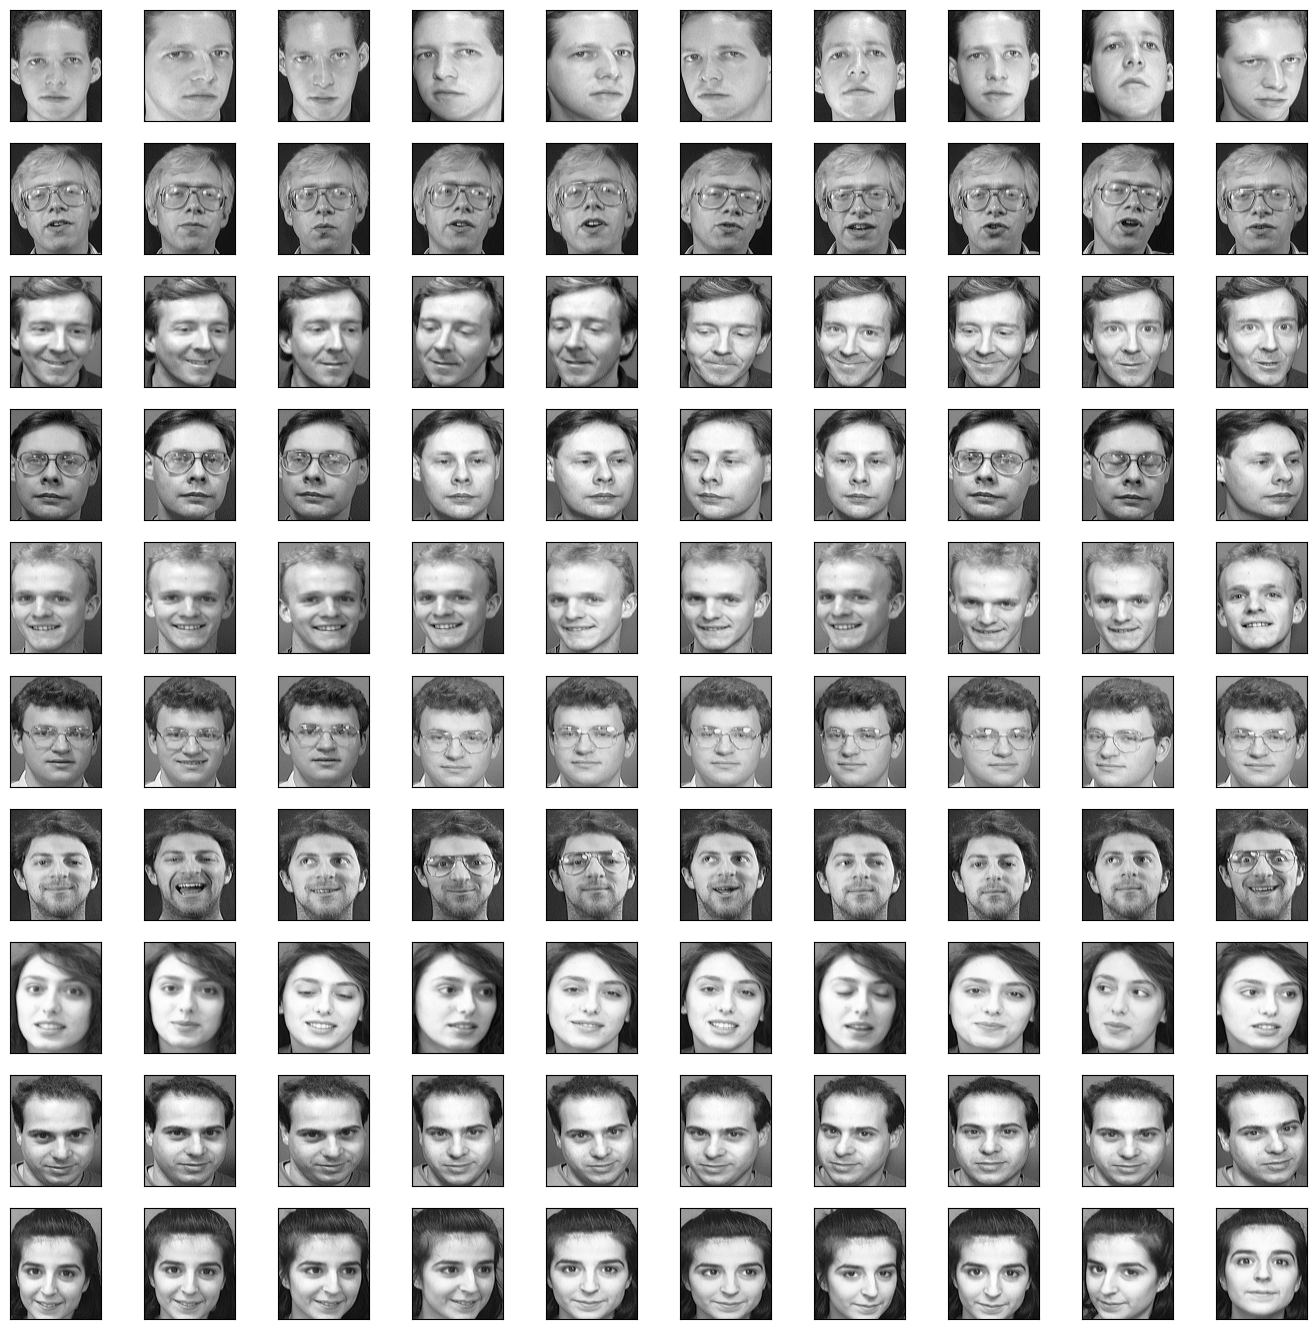

In [7]:
fig, axs = plt.subplots(10, 10, figsize=(17, 17))

for i in range(10):
    for j in range(10):
        ax = axs[i,j ]
        ax.imshow(faces[i, j], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

plt.show()

Let's create the data matrix $X$ (not centered)

In [8]:
X = faces.reshape(-1, height*width) 

In [9]:
X.shape

(400, 10304)

Plot the "average face" (*literally*)

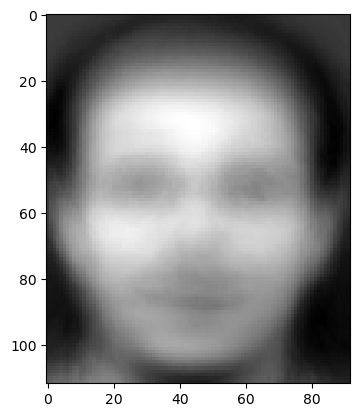

In [10]:
plt.imshow(X.mean(axis=0).reshape(height, width), cmap='gray')
plt.show()

In [11]:
from sklearn.decomposition import PCA

M = 10
pca = PCA(n_components=M)
pca.fit(X) # PCA centers X internally

PCA(n_components=10)

In [12]:
B = pca.components_.T
B.shape

(10304, 10)

Let's plot the **basis vectors** of the principal subspace (Principal Components)

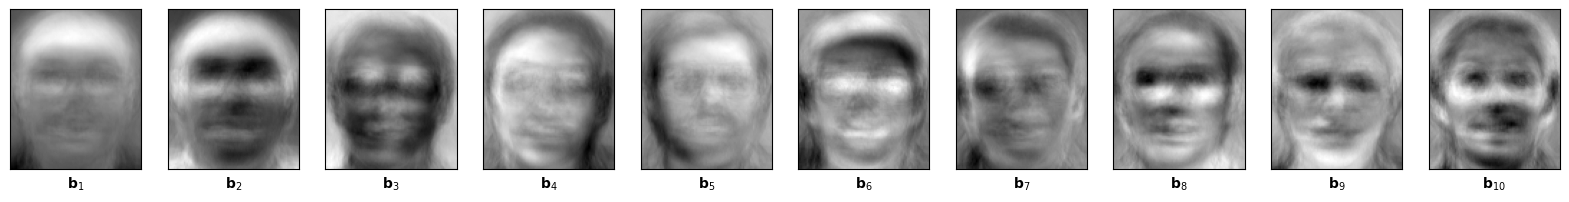

In [13]:
fig, axs = plt.subplots(1, M, figsize=(20, 2.5))

for i in range(M):
    axs[i].imshow(B[:, i].reshape(height, width), cmap='gray')
    axs[i].set_xticks([])
    axs[i].set_xlabel(r'$\mathbf{b}_{' + f'{i+1}' + r'}$')
    axs[i].set_yticks([])

plt.show()

Project all face images into the principal subspace 

In [14]:
X_hat = pca.transform(X)
X_hat.shape

(400, 10)

Reconstruct the first image and plot it

In [15]:
x_recon = B @ X_hat[0, :] + X.mean(axis=0)

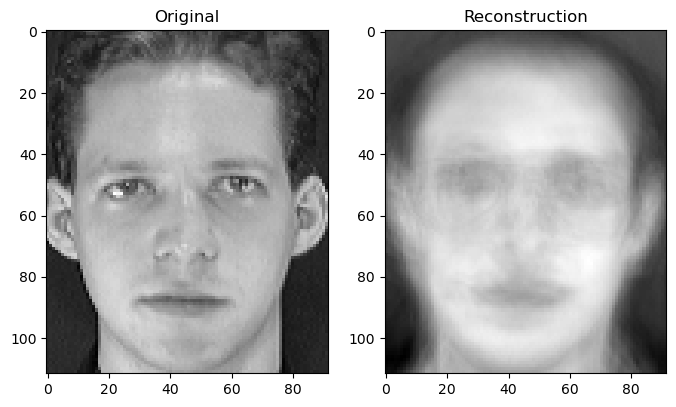

In [16]:
reconstruction_vs_original(X[0, :], x_recon)

In [17]:
def pca_reconstruction_M_components(X, M, img_id=0):
    pca = PCA(n_components=M)
    X_hat = pca.fit_transform(X) # PCA centers X internally
    B = pca.components_.T
    x_recon = B @ X_hat[img_id, :] + X.mean(axis=0)
    print(f'Explained Variance: {np.sum(pca.explained_variance_ratio_) * 100:.2f}%')

    reconstruction_vs_original(X[img_id, :], x_recon)

M=10
Explained Variance: 59.95%


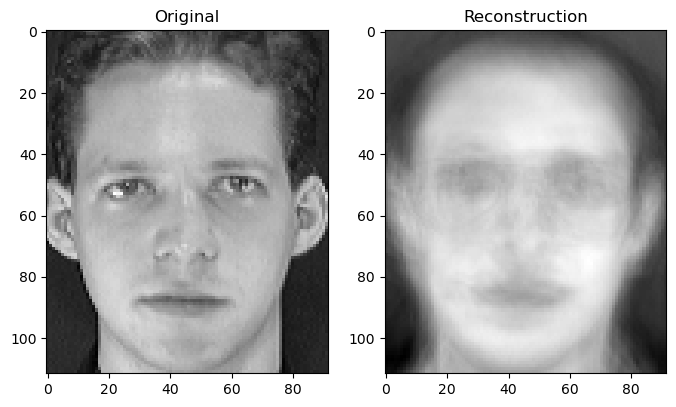

M=50
Explained Variance: 81.56%


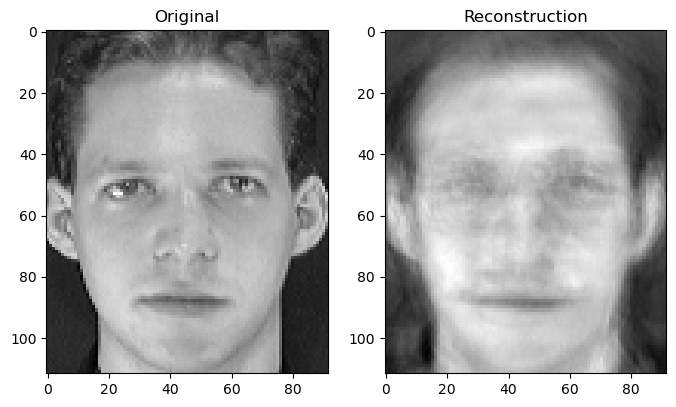

M=100
Explained Variance: 88.98%


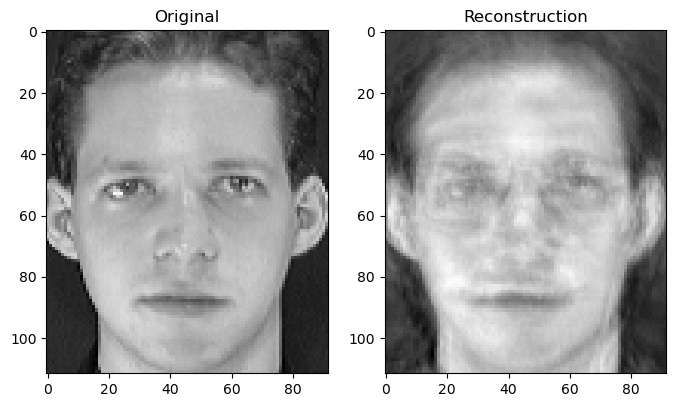

M=200
Explained Variance: 95.39%


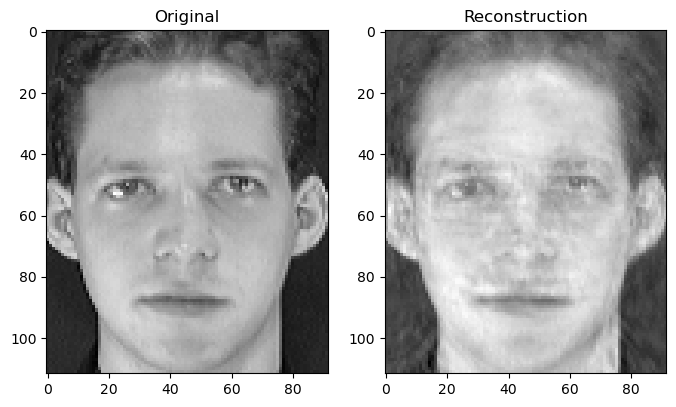

M=400
Explained Variance: 100.00%


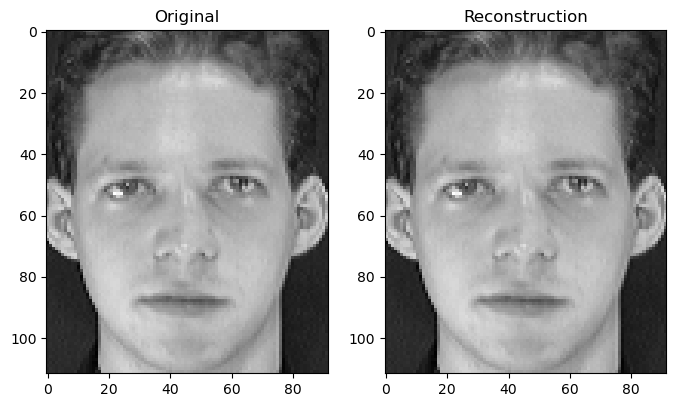

In [18]:
for M in [10, 50, 100, 200, 400]:
    print(f'{M=}')
    pca_reconstruction_M_components(X, M=M, img_id=0)

In [19]:
pca.explained_variance_ratio_ * 100

array([17.60954978, 12.90663627,  6.84104245,  5.57894284,  5.10991269,
        3.36253367,  2.44719674,  2.33106436,  1.96220216,  1.80278034])

In [20]:
np.sum(pca.explained_variance_ratio_)

0.5995186130171899

# A note on implementation

In [21]:
N = X.shape[0]
C = (1/N) * X.T @ X
XXt = (1/N) * X @ X.T

In [22]:
C.shape

(10304, 10304)

In [23]:
XXt.shape

(400, 400)

In [24]:
# That's the thing we really care about - but computing it is super slow!
lamdas_b, eigenvectors_b = np.linalg.eigh(C)

In [ ]:
# Sort by eigenvalues
keys = np.argsort(lamdas_b)[::-1]
lamdas_b = lamdas_b[keys]
eigenvectors_b = eigenvectors_b[:, keys]

In [47]:
# Instead, let's compute eigh for the (much smaller) XXt matrix
lamdas_a, eigenvectors_a = np.linalg.eigh(XXt)

In [48]:
# sort eigenvalues
keys = np.argsort(lamdas_a)[::-1]
lamdas_a = lamdas_a[keys]
eigenvectors_a = eigenvectors_a[:, keys]

In [49]:
# Eigenvalues are the same
assert np.allclose(lamdas_a, lamdas_b[:lamdas_a.shape[0]])

In [26]:
a = eigenvectors_a[:, 0] # pick first eigenvector
l = lamdas_a[0] # and the corresponding eigenvalue

Let's check if $\mathbf{a}$ is indeed an eigenvalue of $\frac{1}{N} XX^T$, i.e.,
$$\frac{1}{N} XX^T\mathbf{a} = \lambda \mathbf{a}$$

In [50]:
assert np.allclose(XXt @ a, l*a)

Thus, $X^T\mathbf{a}$ is an eigenvector of $C$ (with the same eigenvalue $\lambda$):

In [51]:
eigen_of_C = X.T @ a
assert np.allclose(C @ eigen_of_C, l*eigen_of_C)

### Audience Question:
Due to the $XX^T$ trick, we can only compute at most $N$ many principal components, where $N$ is the number of samples. This is because $XX^T$ is of size $N \times N$.

For example,
```
pca_reconstruction_M_components(X, M=500, img_id=0)
```
will fail since $N = 400$ (with the default solver which uses the $XX^T$ trick).
